In [1]:
import pandas as pd
import pytz
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from breaths import *
from getFeatures import *

***Preprocessing***

In [2]:
# Data Cleaning
# 1. Noise removal:- dual-threshold approach atm 0.1Hz - 1.5Hz

RESPECK_FILE = '../../data/bishkek_csr/03_train_ready/CSR003 13.06.2025/13-06-2025_respeck.csv'
PSG_FILE = '../../data/bishkek_csr/03_train_ready/CSR003 13.06.2025/13-06-2025_nasal.csv'
LABELS_FILE = '../../data/bishkek_csr/03_train_ready/CSR003 13.06.2025/13-06-2025_event_export.csv'

# --- Load Data ---
print("Loading data...")

respeck_df = pd.read_csv(RESPECK_FILE)
respeck_df['timestamp'] = pd.to_datetime(respeck_df['alignedTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
respeck_df['timestamp'] = respeck_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# respeck_df.set_index('timestamp', inplace=True)

psg_df = pd.read_csv(PSG_FILE)
psg_df['timestamp'] = pd.to_datetime(psg_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
psg_df['timestamp'] = psg_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# psg_df.set_index('timestamp', inplace=True)

labels_df = pd.read_csv(LABELS_FILE)
labels_df['timestamp'] = pd.to_datetime(labels_df['UnixTimestamp'], unit='ms')
tz = pytz.timezone('Asia/Bishkek')
labels_df['timestamp'] = labels_df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(tz)
# labels_df.set_index('timestamp', inplace=True)

Loading data...


In [3]:
# Only use overalapping data

start_time_respeck = respeck_df['timestamp'].min()
end_time_respeck = respeck_df['timestamp'].max()

start_time_psg = psg_df['timestamp'].min()
end_time_psg = psg_df['timestamp'].max()

overlap_start = max(start_time_respeck, start_time_psg)
overlap_end = min(end_time_respeck, end_time_psg)

print(overlap_start)
print(overlap_end)

overlapping_respeck = respeck_df[(respeck_df['timestamp'] >= overlap_start) & (respeck_df['timestamp'] <= overlap_end)]
overlapping_psg = psg_df[(psg_df['timestamp'] >= overlap_start) & (psg_df['timestamp'] <= overlap_end)]


2025-06-13 23:04:54+06:00
2025-06-14 04:27:06.990000+06:00



Detected Sampling Frequency (fs): 12.50 Hz


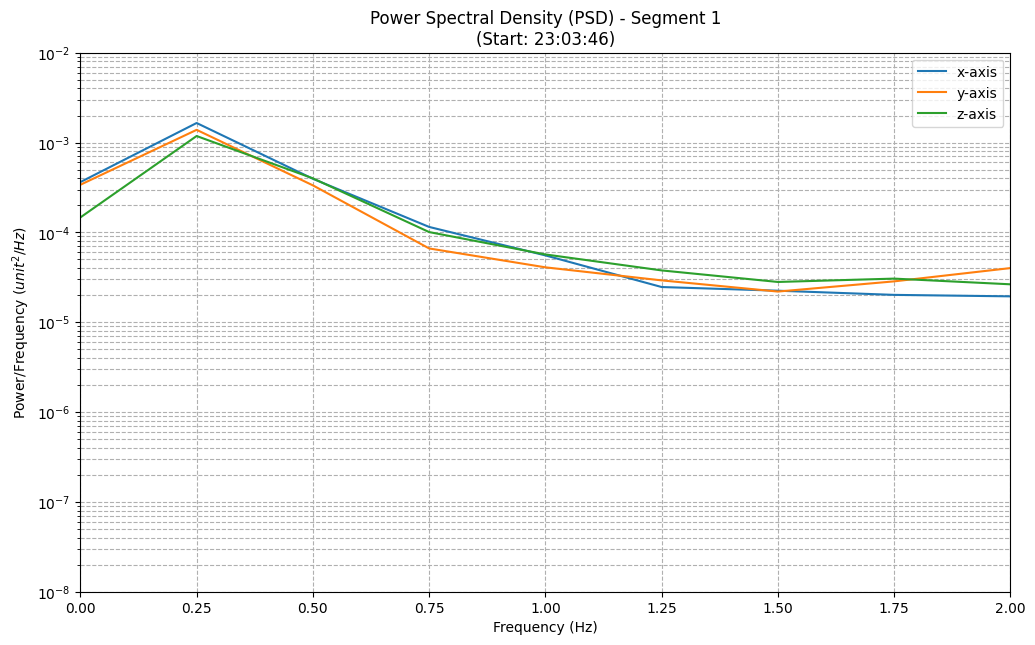

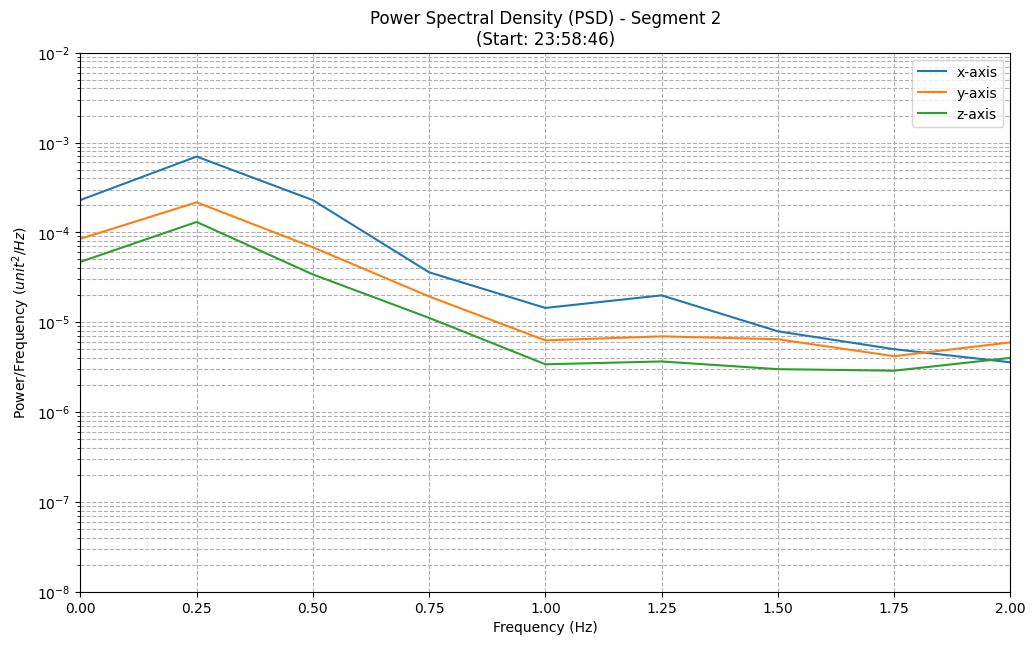

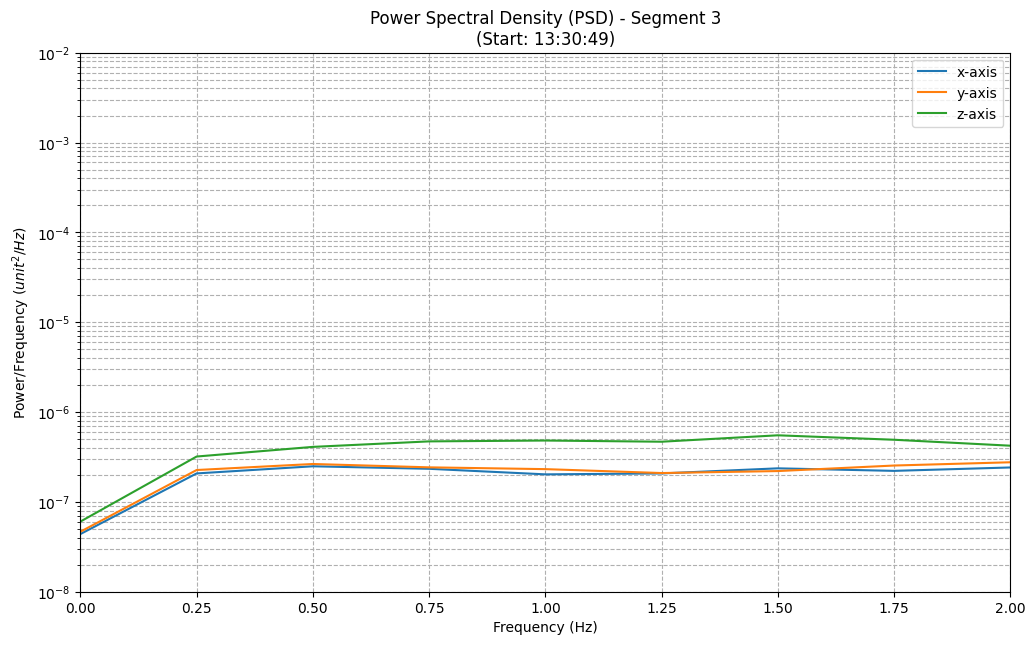

In [4]:

respeck_df.set_index('timestamp', inplace=True)
# Calculate the sampling frequency (fs)
time_diffs = respeck_df.index.to_series().diff().dt.total_seconds()
fs = 1 / time_diffs.median()
print(f"\nDetected Sampling Frequency (fs): {fs:.2f} Hz")

# 3. Define representative segments to analyze
# We'll define the start times for a few 5-minute windows.
# We'll pick a few times from the beginning, middle, and end of the recording.
if not respeck_df.empty:
    segment_starts = [
        respeck_df.index[0] + pd.Timedelta(minutes=5),       # 5 minutes into the recording
        respeck_df.index[0] + pd.Timedelta(minutes=60),      # 60 minutes into the recording
        respeck_df.index[-1] - pd.Timedelta(minutes=10)      # 10 minutes before the end
    ]
    segment_duration = pd.Timedelta(minutes=5)

    # 4. Loop through each segment, compute PSD, and plot
    for i, start_time in enumerate(segment_starts):
        # Select the 5-minute data segment
        end_time = start_time + segment_duration
        segment = respeck_df[start_time:end_time]

        if segment.empty:
            print(f"\nSegment {i+1} starting at {start_time} is empty or too short. Skipping.")
            continue

        # Create a plot for the segment
        plt.figure(figsize=(12, 7))

        # Compute and plot PSD for each axis (x, y, z)
        for axis in ['x', 'y', 'z']:
            # welch returns frequencies and power spectral density
            # nperseg defines the length of each segment for FFT, a larger value gives better frequency resolution
            # We'll use 4 seconds of data for each FFT window (fs * 4)
            frequencies, power = welch(segment[axis], fs=fs, nperseg=fs*4)

            # Use a logarithmic scale for the power axis (semilogy) to see both large and small peaks
            plt.semilogy(frequencies, power, label=f'{axis}-axis')

        plt.title(f'Power Spectral Density (PSD) - Segment {i+1}\n(Start: {start_time.strftime("%H:%M:%S")})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency ($unit^2/Hz$)')
        plt.grid(True, which='both', linestyle='--')
        plt.legend()
        # Limit x-axis to a reasonable range to see details. Frequencies above 2Hz are less common for body movements.
        plt.xlim(0, 2)
        plt.ylim(10e-9, 10e-3) # Set y-axis limits for better comparison between plots
        plt.show()
else:
    print("The DataFrame is empty after loading. Cannot proceed with analysis.")

Using detected sampling frequency of 12.50 Hz.


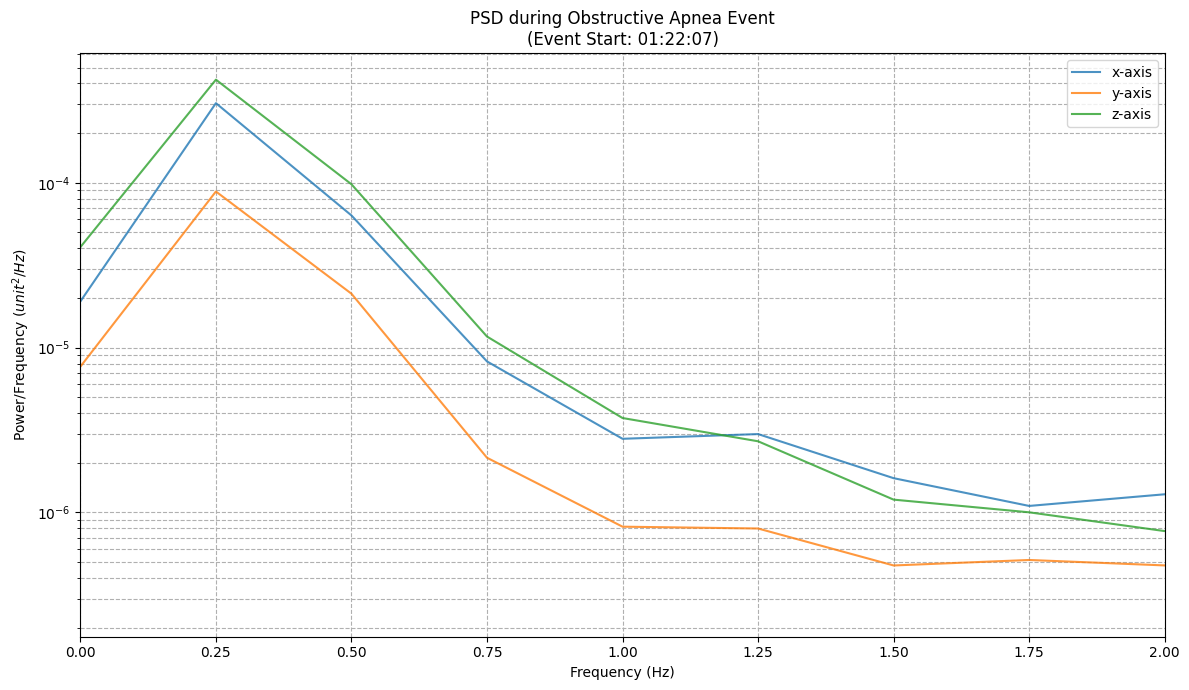

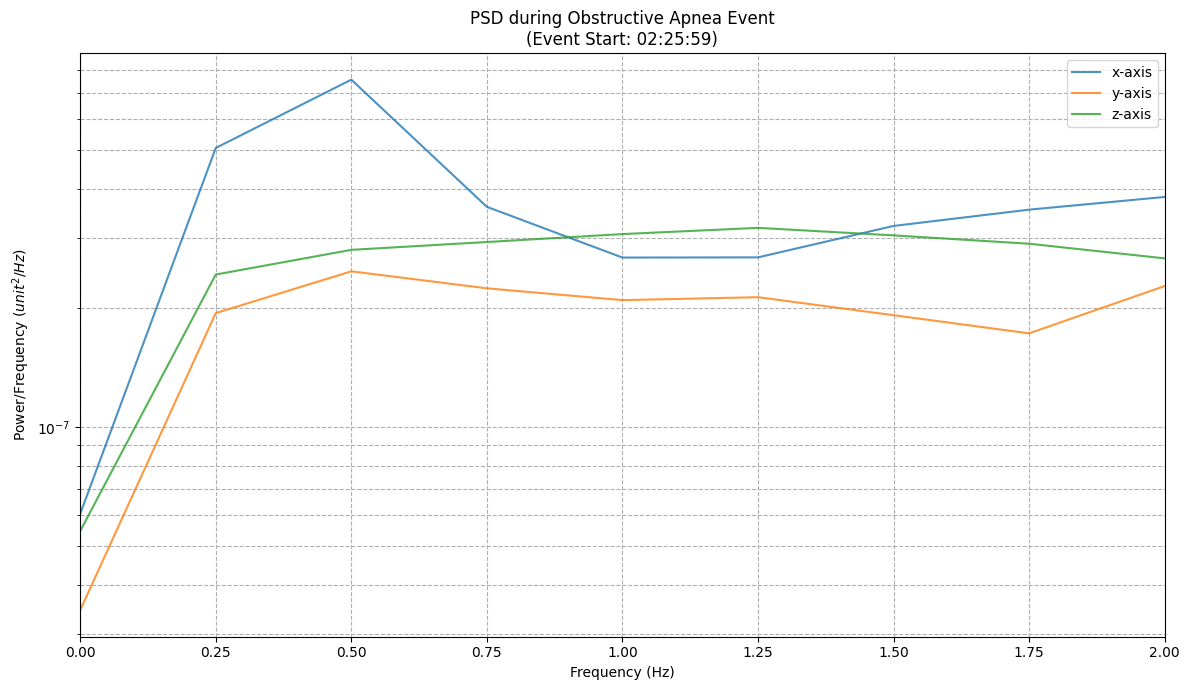

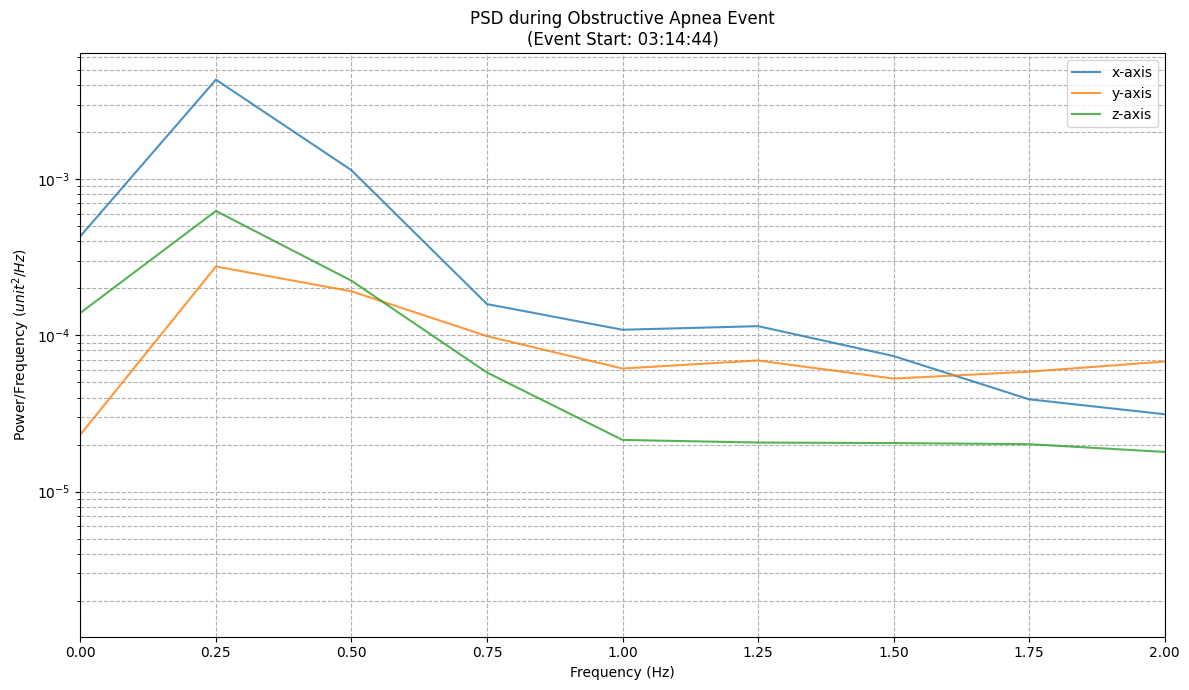

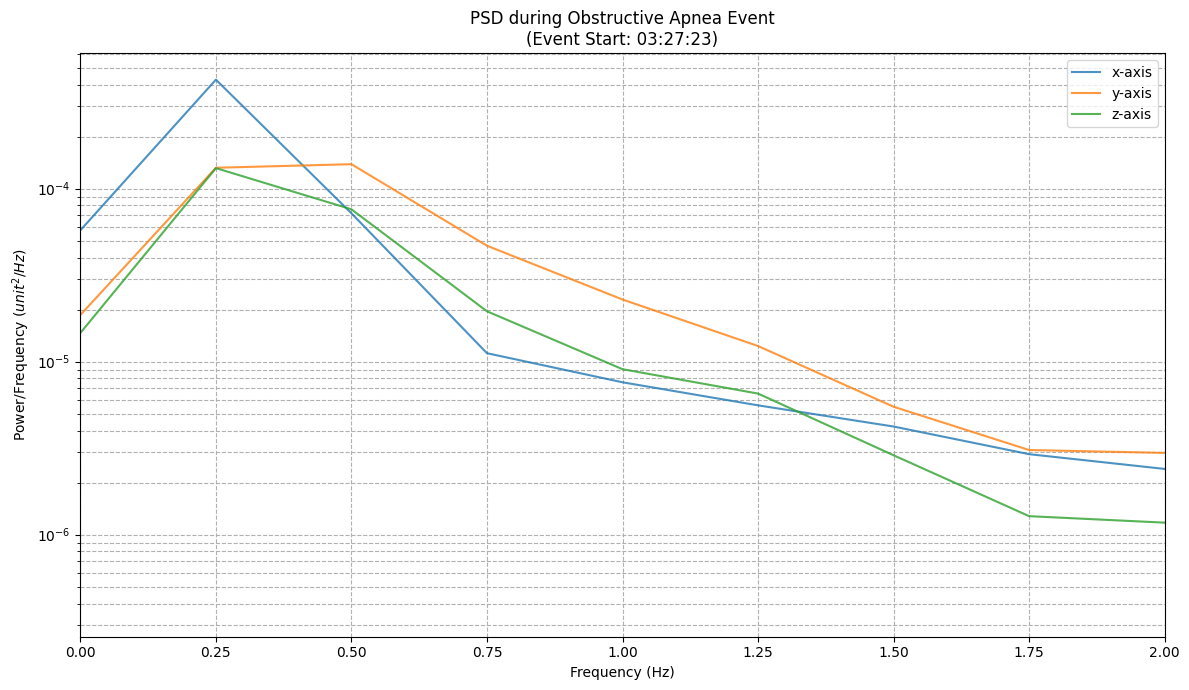

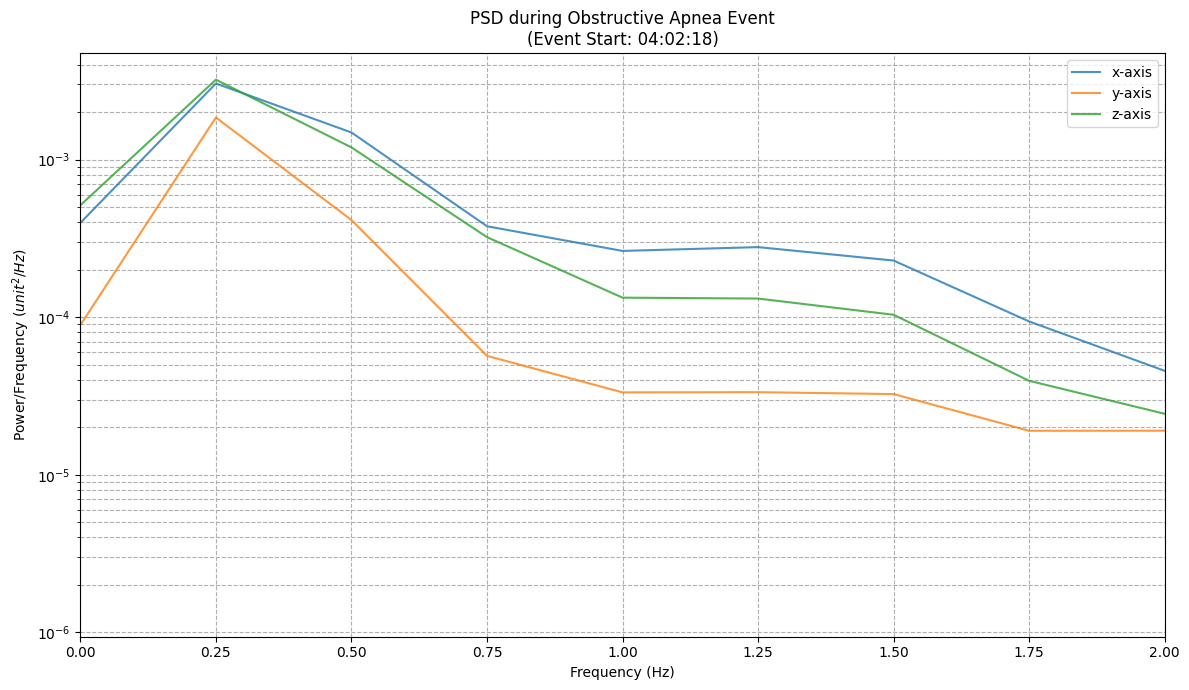

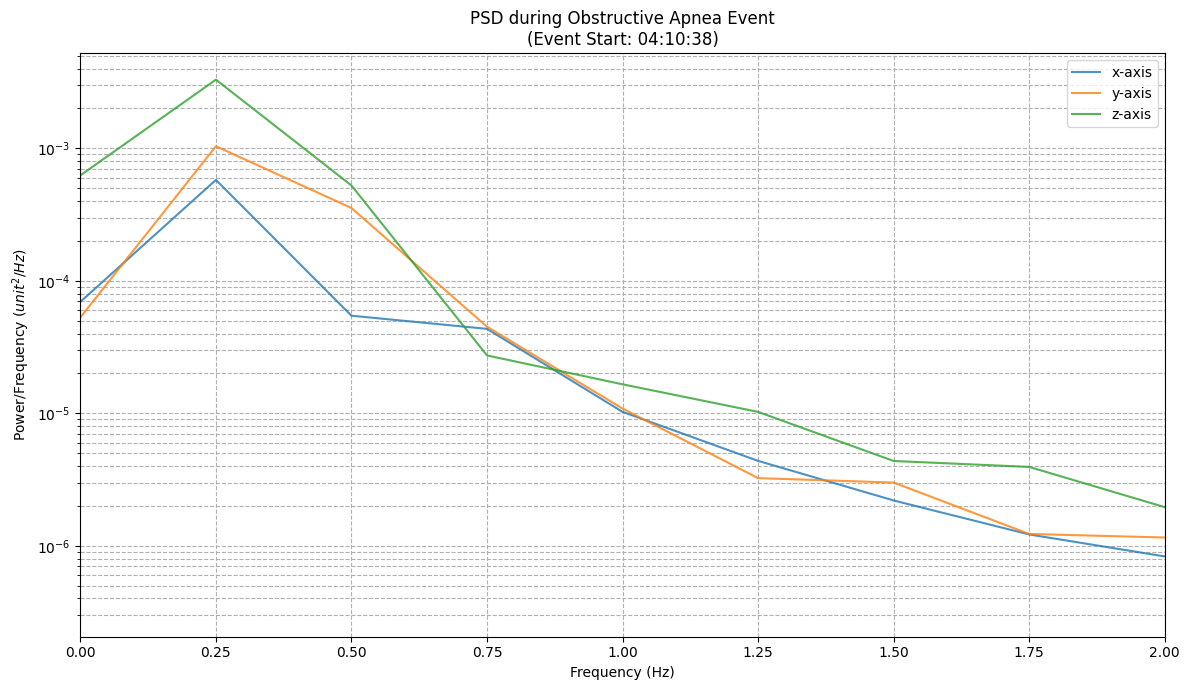

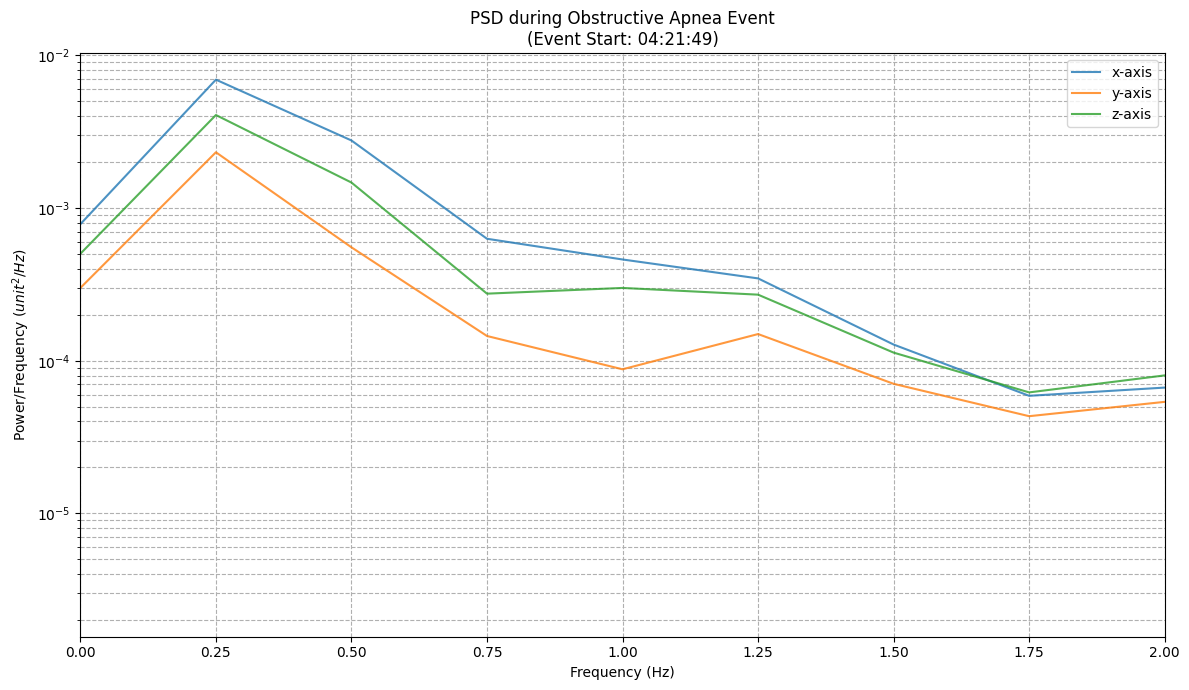

In [5]:
# frequencies for OSA

apnea_events = labels_df[labels_df['Event'] == 'Cheyne-Stokes'].copy()
if not apnea_events.empty:
    # Calculate sampling frequency from the main dataframe
    time_diffs = respeck_df.index.to_series().diff().dt.total_seconds()
    fs = 1 / time_diffs.median()
    print(f"Using detected sampling frequency of {fs:.2f} Hz.")

    for i, event in apnea_events.iterrows():
        start_time = event['timestamp']


        # Extract the signal segment from the main dataframe
        analysis_window_start = start_time - pd.Timedelta(minutes=2.5)
        analysis_window_end = start_time + pd.Timedelta(minutes=2.5)
        
        # Extract the signal segment from the main dataframe using the new window
        segment = respeck_df.loc[analysis_window_start:analysis_window_end]
        
        # Check if the segment is long enough for analysis
        # welch needs at least 2 segments, nperseg should be <= len(segment)
        if segment.shape[0] < fs*2: 
            print(f"\nSkipping event at {start_time.time()} - duration is too short for analysis.")
            continue

        # Create a plot for the segment
        plt.figure(figsize=(12, 7))
        
        # Compute and plot PSD for each axis
        for axis in ['x', 'y', 'z']:
            # nperseg is the segment length for FFT. We can use the length of our event data or a fixed window.
            # It must be <= the length of the segment.
            nperseg = min(segment.shape[0], int(fs * 4)) # Use 4-second window or less if event is shorter
            frequencies, power = welch(segment[axis], fs=fs, nperseg=nperseg)
            plt.semilogy(frequencies, power, label=f'{axis}-axis', alpha=0.8)
        
        plt.title(f'PSD during Obstructive Apnea Event\n(Event Start: {start_time.strftime("%H:%M:%S")})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power/Frequency ($unit^2/Hz$)')
        plt.grid(True, which='both', linestyle='--')
        plt.legend()
        plt.xlim(0, 2) # Focus on frequencies relevant to body movement/breathing
        plt.tight_layout()
        
        plt.show()

else:
    print("\nNo 'Obstructive Apnea' events were found in the provided labels data.")


In [6]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    """
    Applies a zero-phase Butterworth bandpass filter to the data.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    # The butter function returns the filter coefficients (numerator b, denominator a)
    b, a = butter(order, [low, high], btype='band')
    # filtfilt applies the filter forward and backward, resulting in zero phase shift
    y = filtfilt(b, a, data)
    return y


# Based on graph 0.1-0.8Hz
LOWCUT = 0.1  
HIGHCUT = 0.8 

FILTER_ORDER = 4

# --- 6. Visualization for Verification ---

print("Generating plot for verification...")

# Define a time vector for the x-axis of the plot
respeck_df['time_seconds'] = respeck_df['alignedTimestamp'] / 1000.0

# Choose a 60-second segment to visualize
sampling_period = respeck_df['time_seconds'].diff().median()
FS = 1.0 / sampling_period

start_index = 1000
end_index = start_index + int(60 * FS) # 60 seconds of data


print(f"Calculated Sampling Period: {sampling_period:.4f} s")
print(f"Calculated Sampling Frequency (Fs): {FS:.2f} Hz") # Should be close to 12.5 Hz

# Recommended: Calculate the vector magnitude of the accelerometer signal
# This creates a single signal that is robust to sensor orientation.

print("Calculating vector magnitude from x, y, z axes...")
accel_mag = np.sqrt(respeck_df['x']**2 + respeck_df['y']**2 + respeck_df['z']**2)
accel_mag_detrended = accel_mag - accel_mag.mean()

print(f"Applying {LOWCUT}-{HIGHCUT}Hz bandpass filter...")

filtered_breathing_signal = butter_bandpass_filter(
    data=accel_mag_detrended.values, 
    lowcut=LOWCUT, 
    highcut=HIGHCUT, 
    fs=FS, 
    order=FILTER_ORDER
)

respeck_df['breathing_signal_filtered'] = filtered_breathing_signal
print("Added 'breathing_signal_filtered' column to the DataFrame.")

Generating plot for verification...
Calculated Sampling Period: 0.0800 s
Calculated Sampling Frequency (Fs): 12.50 Hz
Calculating vector magnitude from x, y, z axes...
Applying 0.1-0.8Hz bandpass filter...
Added 'breathing_signal_filtered' column to the DataFrame.


Generating plot for verification...


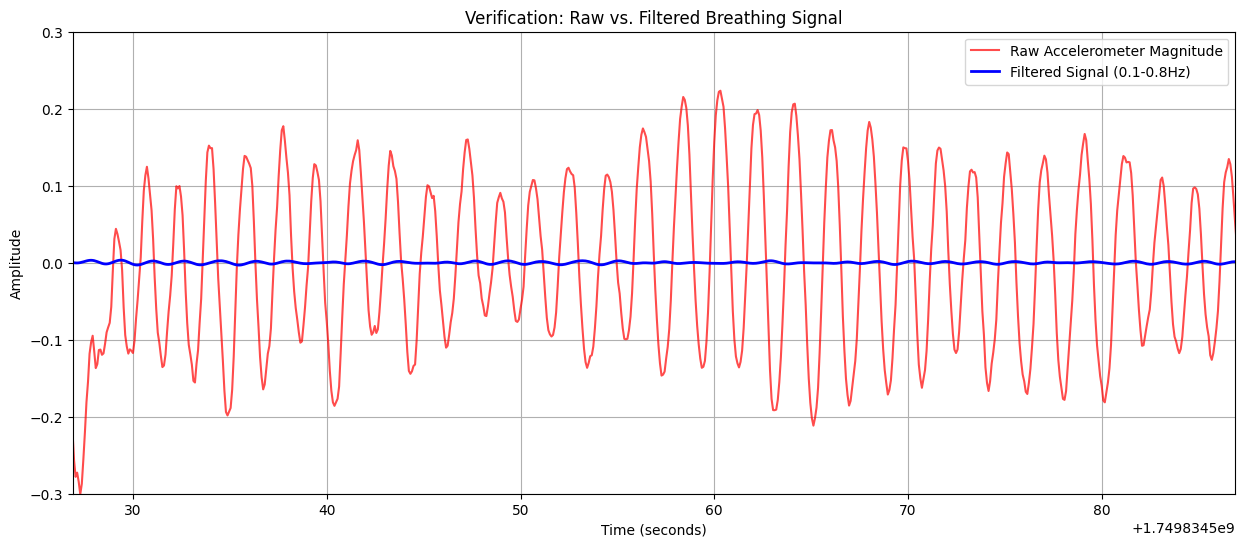

In [7]:
print("Generating plot for verification...")

# Choose a 60-second segment to visualize
# We'll plot from 10 minutes (600s) to 11 minutes (660s) into the recording
start_time_plot = respeck_df['time_seconds'].iloc[0] + 600
end_time_plot = start_time_plot + 60

plt.figure(figsize=(15, 6))

#Use the 'time_seconds' column directly for the x-axis
plt.plot(respeck_df['time_seconds'],
         respeck_df['breathingSignal'],
         label='Raw Accelerometer Magnitude',
         color='red',
         alpha=0.7)

plt.plot(respeck_df['time_seconds'],
         respeck_df['breathing_signal_filtered'],
         label=f'Filtered Signal ({LOWCUT}-{HIGHCUT}Hz)',
         color='blue',
         linewidth=2)

# Set the plot limits to our desired time window
plt.xlim(start_time_plot, end_time_plot)
plt.ylim(-0.3,0.3)
plt.title('Verification: Raw vs. Filtered Breathing Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [8]:

respeck_df = respeck_df.reset_index()
print(getBreaths(respeck_df))

Uses Breath From 120344/638626 = 18.84% Signal
Max Breath Length: 232 points. Min Breath Length: 5 points
[[1358, 1448], [1485, 1499, 1531, 1549, 1574, 1620], [2179, 2216, 2276], [2804, 2824, 2849, 2872], [3526, 3546, 3567, 3588, 3607, 3679, 3698, 3730, 3752, 3770, 3790, 3814, 3879, 3901, 3926], [4341, 4361, 4384, 4399, 4422, 4446, 4469, 4495, 4529, 4543, 4571, 4595], [4641], [5274, 5295, 5317, 5385, 5414, 5425, 5456, 5476, 5500, 5522, 5545, 5567, 5590, 5614], [6519, 6577, 6606, 6635, 6683, 6703, 6718, 6742, 6762, 6781, 6802, 6822, 6840, 6878, 6908, 6938, 6959, 6980, 7001, 7021, 7041, 7063, 7097, 7180, 7197, 7215, 7234, 7255, 7273, 7293, 7312, 7333, 7355, 7374, 7394, 7415, 7437, 7457, 7481, 7513, 7548, 7569, 7589, 7610, 7634, 7658, 7678], [7729, 7752, 7778, 7798, 7820, 7843, 7868, 7892, 7917, 7941, 7964, 7988, 8012, 8037, 8060, 8082, 8102, 8125, 8150, 8175], [8877, 8899, 8924, 8948, 8971, 8995, 9019, 9043, 9066, 9090, 9114, 9136, 9161, 9184, 9207, 9226, 9251, 9271, 9293, 9315], [9540, 

In [9]:
respeck_df['breathingSignal'] = respeck_df['breathing_signal_filtered'] * 100

print(getBreaths(respeck_df))

Uses Breath From 210564/646272 = 32.58% Signal
Max Breath Length: 129 points. Min Breath Length: 7 points
[[228, 248, 260, 279, 303, 318, 422, 456, 470], [562, 644, 761, 853, 902, 982, 1036, 1059, 1080, 1111, 1126, 1164, 1227, 1308, 1404, 1428, 1448, 1469, 1488, 1514], [1553, 1580, 1602, 1638, 1702, 1721, 1739, 1759, 1819, 1846, 1866, 1883, 1902, 1919, 1942, 2018, 2054, 2103, 2121, 2142, 2171, 2188, 2205, 2225, 2271, 2291, 2319, 2353, 2367, 2392, 2411, 2453, 2468, 2484, 2540, 2555, 2578, 2592, 2626, 2647, 2673, 2696, 2719, 2748, 2761, 2786, 2812, 2833, 2854, 2878, 2903], [3550, 3572, 3590, 3616, 3638, 3658, 3683, 3711, 3733, 3754, 3801, 3844, 3863, 3886, 3906, 3927], [4002], [5002], [5413, 5437, 5458, 5484, 5505, 5527, 5553, 5575, 5597, 5662, 5704, 5771, 5842, 5864, 5907, 5974, 6025, 6052, 6070, 6180, 6259, 6380, 6490, 6575, 6588, 6611, 6632, 6652, 6670, 6688, 6704, 6725, 6746, 6765, 6783, 6803, 6824, 6865, 6881, 6923, 6943, 6962, 6982, 7002, 7022, 7046, 7085, 7120, 7159, 7179, 7197, 7

In [10]:
# Extract Features
breath_features = extractFeatures(respeck_df)
print(breath_features)

Uses Breath From 210564/646272 = 32.58% Signal
Max Breath Length: 129 points. Min Breath Length: 7 points
0/279...  25/279...  50/279...  75/279...  100/279...  125/279...  150/279...  175/279...  200/279...  225/279...  250/279...  275/279...               type      area  peakRespiratoryFlow  extremas  duration  \
0      Inhalation  2.541793             5.002665         2      0.88   
1      Exhalation  0.438523             1.574110         2      0.64   
2      Inhalation  0.439717             1.438313         2      0.48   
3      Exhalation  0.013775             1.217155         2      0.40   
4      Inhalation  1.684973             4.093507         2      0.64   
...           ...       ...                  ...       ...       ...   
15384  Exhalation  0.442603             1.005346         2      0.96   
15385  Inhalation  1.215536             0.993286         3      3.44   
15386  Exhalation  0.425348             0.144144         4      4.80   
15387  Inhalation  0.166992        

In [12]:
features_df = combineDfs(breath_features, respeck_df)

In [18]:
print(features_df.columns)

Index(['type', 'startTimestamp', 'endTimestamp', 'area', 'extremas',
       'meanActivityLevel', 'modeActivityType', 'peakRespiratoryFlow',
       'duration', 'BR_md', 'BR_mean', 'BR_std', 'AL_md', 'AL_mean', 'AL_std',
       'RRV', 'RRV3MA', 'breath_regularity'],
      dtype='object')


In [19]:
breath_regularity_feature = compute_breath_regularity(features_df)